In [1]:


import os, glob, random, shutil, time
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models


In [ ]:
BASE_DIR = r"D:\datasets\chest_xray"  # <- set to the OUTER folder you see
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
LR = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 4
SEED = 42
SAVE_PATH = "best_resnet18_pneumonia.pt"

random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

Device: cuda


C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_34360\3011490712.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [4]:
def find_dataset_root(base_dir):
    # Accept both:
    # base/chest_xray/{train,val,test}   OR   base/{train,val,test}
    candidates = [base_dir]
    candidates += [p for p in glob.glob(os.path.join(base_dir, "*")) if os.path.isdir(p)]
    for c in candidates:
        # skip __MACOSX
        if os.path.basename(c).lower().startswith("__macosx"): 
            continue
        if all(os.path.isdir(os.path.join(c, d)) for d in ["train", "val", "test"]):
            return c
    raise FileNotFoundError("Could not find train/val/test inside base dir.")

In [5]:
DATA_ROOT = find_dataset_root(BASE_DIR)
print("Dataset root:", DATA_ROOT)

Dataset root: D:\datasets\chest_xray


In [6]:


train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # X-rays are grayscale; ResNet expects 3 channels
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [7]:
train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_ROOT, "val"),   transform=val_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_ROOT, "test"),  transform=val_tfms)

In [8]:

print("Classes:", train_ds.classes)  # ['NORMAL', 'PNEUMONIA'] expected
num_classes = len(train_ds.classes)

Classes: ['NORMAL', 'PNEUMONIA']


In [9]:
def make_weights_for_balanced_classes(dataset):
    targets = [y for _, y in dataset.samples]
    counts = Counter(targets)
    total = sum(counts.values())
    class_weights = {cls: total / (len(counts) * cnt) for cls, cnt in counts.items()}
    sample_weights = [class_weights[y] for _, y in dataset.samples]
    return sample_weights, torch.tensor([class_weights[i] for i in range(len(counts))], dtype=torch.float)

train_sample_weights, class_weights_tensor = make_weights_for_balanced_classes(train_ds)
sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)


In [10]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)



In [11]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# Replace classifier
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [13]:
def run_epoch(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()

    epoch_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, labels)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        epoch_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return epoch_loss / total, correct / total


In [14]:
best_val_acc, best_state = 0.0, None
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = run_epoch(train_loader, train_mode=True)
    val_loss, val_acc = run_epoch(val_loader, train_mode=False)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "val_acc": best_val_acc,
            "classes": train_ds.classes,
            "img_size": IMG_SIZE,
        }
        torch.save(best_state, SAVE_PATH)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"best_val_acc={best_val_acc:.4f} | "
          f"{(time.time()-t0):.1f}s")

print(f"Best model saved to: {SAVE_PATH}")

C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_34360\246375462.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


Epoch 01/15 | train_loss=0.1206 acc=0.9427 | val_loss=0.6831 acc=0.6875 | best_val_acc=0.6875 | 84.6s
Epoch 02/15 | train_loss=0.0732 acc=0.9651 | val_loss=0.2789 acc=0.9375 | best_val_acc=0.9375 | 74.8s
Epoch 03/15 | train_loss=0.0578 acc=0.9701 | val_loss=0.2079 acc=0.9375 | best_val_acc=0.9375 | 71.6s
Epoch 04/15 | train_loss=0.0426 acc=0.9789 | val_loss=0.9080 acc=0.6875 | best_val_acc=0.9375 | 70.2s
Epoch 05/15 | train_loss=0.0365 acc=0.9808 | val_loss=1.6388 acc=0.7500 | best_val_acc=0.9375 | 72.8s
Epoch 06/15 | train_loss=0.0323 acc=0.9812 | val_loss=1.7224 acc=0.5625 | best_val_acc=0.9375 | 73.1s
Epoch 07/15 | train_loss=0.0343 acc=0.9839 | val_loss=0.7644 acc=0.6875 | best_val_acc=0.9375 | 72.5s
Epoch 08/15 | train_loss=0.0278 acc=0.9873 | val_loss=0.3600 acc=0.9375 | best_val_acc=0.9375 | 73.2s
Epoch 09/15 | train_loss=0.0186 acc=0.9908 | val_loss=0.4541 acc=0.8750 | best_val_acc=0.9375 | 72.2s
Epoch 10/15 | train_loss=0.0184 acc=0.9904 | val_loss=1.5288 acc=0.6250 | best_val

In [15]:
ckpt = torch.load(SAVE_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

C:\Users\Ekaansh\AppData\Local\Temp\ipykernel_34360\453618918.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(SAVE_PATH, map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nTest Report:")
print(classification_report(all_labels, all_preds, target_names=train_ds.classes, digits=4))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Test Report:
              precision    recall  f1-score   support

      NORMAL     0.9661    0.7308    0.8321       234
   PNEUMONIA     0.8591    0.9846    0.9176       390

    accuracy                         0.8894       624
   macro avg     0.9126    0.8577    0.8748       624
weighted avg     0.8992    0.8894    0.8855       624

Confusion Matrix:
 [[171  63]
 [  6 384]]


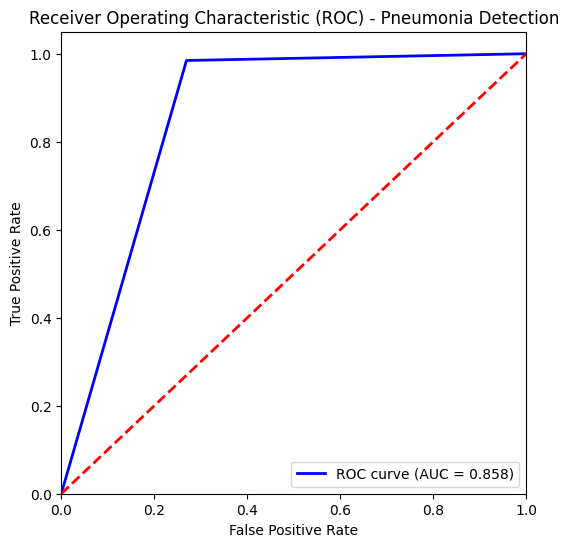

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
import numpy as np

# If your model outputs probabilities, use them:
# e.g., all_probs = model_outputs[:, 1]  # probability of class=1 (Pneumonia)

# If you only have predictions (0/1), just use that (less informative)
all_probs = all_preds  # replace this with actual probabilities if available

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Pneumonia Detection")
plt.legend(loc="lower right")
plt.show()
